In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

## 0. Downloading the data and taking a look at it

In [0]:
path = untar_data(URLs.IMAGENETTE_160)

In [0]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

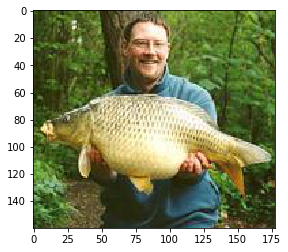

In [4]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [0]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [0]:
files = getListOfFiles(str(path))

In [0]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [0]:
class CustomDataset(Dataset):
    def __init__(self, files, window_size=30, tfms=None):
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = io.imread(self.files[idx])
        if len(img.shape) < 3:
            aux = np.zeros(shape=(img.shape[0],img.shape[1],3), dtype=np.uint8)
            aux[:,:,0] = img
            aux[:,:,1] = img
            aux[:,:,2] = img
            img = aux

        if self.tfms:
            #try:
            img = self.tfms(Image.fromarray(img))
            #except:
            #    print(self.files[idx])
            #    print(img.shape)
            #    import pdb;pdb.set_trace()

        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[0,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.485)/0.229
        img_window[1,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.456)/0.224
        img_window[2,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.406)/0.225


        sample = (img_window,img)
        
        return sample

In [0]:
tfms_train = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.75,1.25), contrast=(0.75,1.25), saturation=(0.5,1.25)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
tfms_valid = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [0]:
train_ds = CustomDataset(files_train,tfms=tfms_train,window_size=32)
valid_ds = CustomDataset(files_val,tfms=tfms_valid,window_size=32)

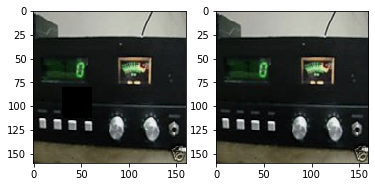

In [13]:
train_ds.show(0)

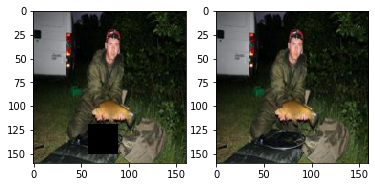

In [14]:
valid_ds.show(0)

In [0]:
train_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)

In [0]:
inputs, classes = next(iter(train_dl))

In [17]:
inputs.shape, classes.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 3, 160, 160]))

## 2. Creating the model

In [0]:
mdl = models.resnet34(pretrained=True)

In [0]:
encoder = nn.Sequential(*list(mdl.children())[:-2])

In [20]:
c = encoder(inputs)
c.shape

torch.Size([16, 512, 5, 5])

In [0]:
#Putting a decoder on top of my encoder
fillNet = DynamicUnet(encoder, 3, img_size=(160,160),self_attention=True)

In [22]:
bla = fillNet(inputs)
bla.shape

torch.Size([16, 3, 160, 160])

## 3. Creating the Databunch and Learner

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
learn = Learner(data, fillNet, loss_func=nn.MSELoss(), metrics = [psnr], callback_fns=ShowGraph)

In [0]:
#creating the layer groups so that I can use discriminative learning rates
_ = learn.split([learn.model.layers[:2], 
             learn.model.layers[2:4], 
             learn.model.layers[4:6],
             learn.model.layers[6:8],
             learn.model.layers[8:10],
             learn.model.layers[10:]])

In [0]:
#first, fit only the decoder
for child in learn.model[0].children():
    for params in child.parameters():
        params.requires_grad = False

for child in learn.model[1].children():
    for params in child.parameters():
        params.requires_grad = False

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,psnr,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-04
Min loss divided by 10: 3.31E-01


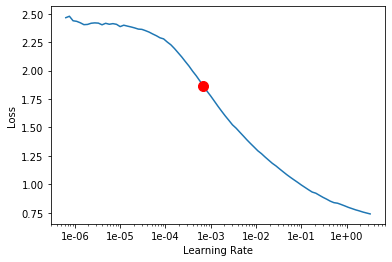

In [28]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,psnr,time
0,0.133160,0.088673,10.551304,02:39
1,0.086342,0.040837,13.927934,02:39
2,0.054933,0.036805,14.385277,02:39
3,0.054299,0.018600,17.416142,02:40
4,0.054179,0.019141,17.265965,02:39
5,0.049358,0.023313,16.381664,02:40
6,0.047508,0.016370,17.959282,02:40
7,0.055165,0.034788,17.641859,02:39
8,0.050848,0.016053,18.051941,02:40
9,0.048042,0.017872,17.569550,02:39


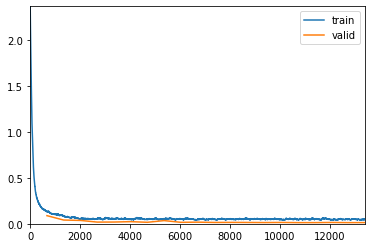

Better model found at epoch 0 with valid_loss value: 0.08867267519235611.
Better model found at epoch 1 with valid_loss value: 0.040836937725543976.
Better model found at epoch 2 with valid_loss value: 0.03680529445409775.
Better model found at epoch 3 with valid_loss value: 0.018600061535835266.
Better model found at epoch 6 with valid_loss value: 0.016370370984077454.
Better model found at epoch 8 with valid_loss value: 0.016053136438131332.
Better model found at epoch 10 with valid_loss value: 0.014666469767689705.
Better model found at epoch 12 with valid_loss value: 0.014557218179106712.
Better model found at epoch 13 with valid_loss value: 0.013531393371522427.
Better model found at epoch 15 with valid_loss value: 0.012759625911712646.


In [29]:
learn.fit_one_cycle(20, max_lr=6.92e-4,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')],)

In [0]:
def show_results(learn,figsize=(5,5)):
    inputs,classes = next(iter(learn.data.valid_dl))
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    mse = np.sum(((pred - target)**2))/(pred.shape[0]*pred.shape[1]*pred.shape[2])
    psnr = 10*np.log10(255/mse)

    print('MSE:',mse)
    print('PSNR:', psnr)

    #import pdb;pdb.set_trace()

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

In [0]:
_ = learn.load('stage-1')

MSE: 10.040002654011452
PSNR: 14.048063528219291


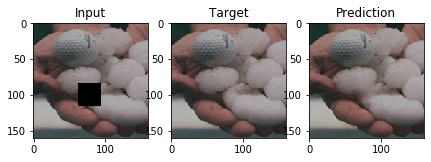

In [34]:
show_results(learn,figsize=(7,7))

MSE: 62.74776177113963
PSNR: 6.089419414008752


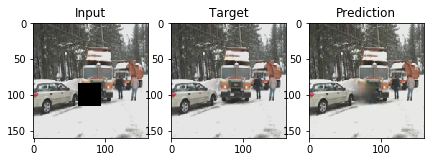

In [37]:
show_results(learn,figsize=(7,7))

MSE: 32.14810197376857
PSNR: 8.993848431939872


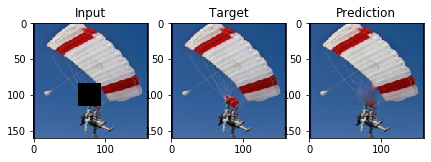

In [38]:
show_results(learn,figsize=(7,7))

MSE: 17.175679954480703
PSNR: 11.716262414194777


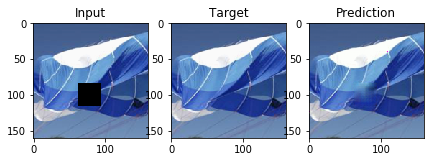

In [39]:
show_results(learn,figsize=(7,7))

In [0]:
#unfreezing the encoder
for child in learn.model[0].children():
    for params in child.parameters():
        params.requires_grad = True

for child in learn.model[1].children():
    for params in child.parameters():
        params.requires_grad = True

epoch,train_loss,valid_loss,psnr,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


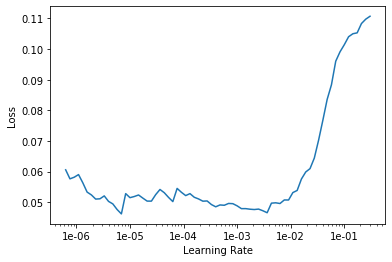

In [41]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,psnr,time
0,0.054232,0.013426,18.856497,03:00
1,0.047743,0.014160,18.607208,03:00
2,0.050345,0.012871,19.053846,03:00
3,0.051904,0.015766,18.122818,03:00
4,0.054771,0.016244,17.983492,03:00
5,0.040494,0.014397,18.515615,03:00
6,0.050712,0.014452,18.515350,03:00
7,0.050266,0.015448,18.210749,03:00
8,0.055553,0.014318,18.546892,03:00
9,0.054245,0.016927,17.791872,03:00


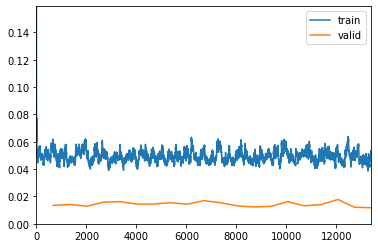

Better model found at epoch 0 with valid_loss value: 0.01342607568949461.
Better model found at epoch 2 with valid_loss value: 0.01287088356912136.
Better model found at epoch 12 with valid_loss value: 0.012296624481678009.
Better model found at epoch 18 with valid_loss value: 0.012103606015443802.
Better model found at epoch 19 with valid_loss value: 0.011748095974326134.


In [42]:
learn.fit_one_cycle(20, slice(1e-5,1e-3),
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [0]:
_ = learn.load('stage-2')

MSE: 22.43521554971928
PSNR: 10.556099339950398


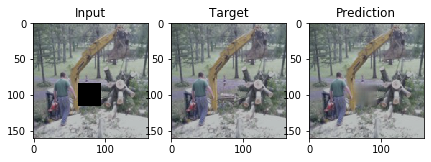

In [44]:
show_results(learn,figsize=(7,7))

MSE: 5.699760709003543
PSNR: 16.506835572072138


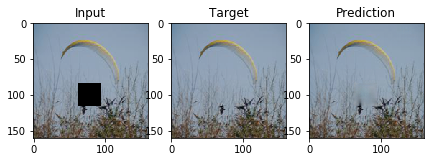

In [45]:
show_results(learn,figsize=(7,7))

MSE: 32.114734445000956
PSNR: 8.998358452265276


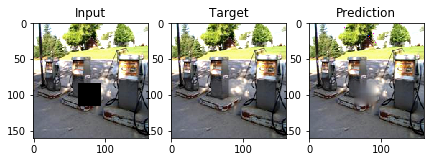

In [46]:
show_results(learn,figsize=(7,7))

MSE: 42.13952544711033
PSNR: 7.8185053992746045


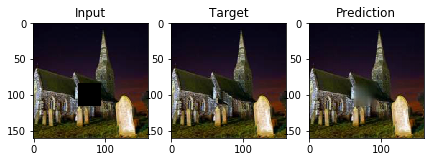

In [47]:
show_results(learn,figsize=(7,7))

MSE: 40.840448741255656
PSNR: 7.954496751096687


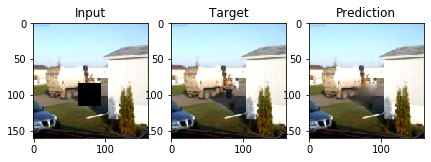

In [48]:
show_results(learn,figsize=(7,7))